In [14]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import itertools

In [15]:
DATA_PATH = "C:/Users/joshd/Documents/BTech Project Sem-7/btech_project/audio_emotion_detection/RAVDESS_audio_dataset"   # <-- set this to where your WAV files are
SR = 22050                    # sampling rate for librosa.load
N_MFCC = 40                   # number of MFCC coefficients
MAX_PAD_LEN = 174             # number of time frames to pad/truncate to (tunable)
BATCH_SIZE = 32
EPOCHS = 40
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_OUT = "ravdess_ser_cnn.h5"

In [16]:
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [17]:
def extract_emotion_from_filename(filename):
    # filename is e.g. .../03-01-05-01-02-01-12.wav
    base = os.path.basename(filename)
    parts = base.split('.')[0].split('-')
    if len(parts) < 3:
        return None
    emo_code = parts[2]
    return EMOTIONS.get(emo_code)

def pad_or_truncate(mfcc, max_len=MAX_PAD_LEN):
    # mfcc shape: (n_mfcc, time)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

In [18]:
def extract_features(file_path, sr=SR, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    # load audio
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    # compute MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # compute deltas
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # stack MFCC + delta + delta2 (resulting in channels = 3)
    stacked = np.vstack([mfcc, delta, delta2])  # shape (n_mfcc*3, time)
    # pad / truncate in time dimension
    stacked = pad_or_truncate(stacked, max_pad_len)
    return stacked

In [19]:
def load_dataset(data_path):
    pattern = os.path.join(data_path, '**', '*.wav')
    files = glob.glob(pattern, recursive=True)
    print(f"Found {len(files)} wav files.")
    X, Y = [], []
    for f in files:
        emo = extract_emotion_from_filename(f)
        if emo is None:
            continue
        feat = extract_features(f)
        if feat is None:
            continue
        X.append(feat)
        Y.append(emo)
    X = np.array(X)
    Y = np.array(Y)
    print("X shape (num_samples, features, time):", X.shape)
    return X, Y

In [20]:
def build_cnn_model(input_shape, num_classes):
    # input_shape: (channels, time) where channels = n_mfcc*3
    # We'll treat input as "image" with shape (channels, time, 1)
    inp = layers.Input(shape=(input_shape[0], input_shape[1], 1))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [21]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}"
        plt.text(j, i, val,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Found 2880 wav files.
X shape (num_samples, features, time): (2880, 120, 174)
Emotions in data: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Train shape: (2304, 120, 174, 1) (2304, 8)
Test shape: (576, 120, 174, 1) (576, 8)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 174, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 174, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 174, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.2424 - loss: 1.9460

65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.2885 - loss: 1.8461 - val_accuracy: 0.3117 - val_loss: 1.8542
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.3932 - loss: 1.5826 - val_accuracy: 0.1645 - val_loss: 1.9576
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4825 - loss: 1.4220

65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - accuracy: 0.5128 - loss: 1.3840 - val_accuracy: 0.2468 - val_loss: 1.7481
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5502 - loss: 1.2508

65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.5620 - loss: 1.2268 - val_accuracy: 0.4545 - val_loss: 1.5646
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.6165 - loss: 1.0845 - val_accuracy: 0.3550 - val_loss: 1.5768
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.6831 - loss: 0.9221 - val_accuracy: 0.2944 - val_loss: 1.5995
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7349 - loss: 0.7957

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - accuracy: 0.7405 - loss: 0.7816 - val_accuracy: 0.5281 - val_loss: 1.3047
Epoch 8/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 365ms/step - accuracy: 0.7873 - loss: 0.6531 - val_accuracy: 0.4589 - val_loss: 1.5443
Epoch 9/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8486 - loss: 0.5210

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.8456 - loss: 0.5198 - val_accuracy: 0.5368 - val_loss: 1.1724
Epoch 10/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8582 - loss: 0.4519

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - accuracy: 0.8698 - loss: 0.4359 - val_accuracy: 0.6407 - val_loss: 1.0372
Epoch 11/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.9059 - loss: 0.3411 - val_accuracy: 0.3896 - val_loss: 1.7233
Epoch 12/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9138 - loss: 0.2961

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 372ms/step - accuracy: 0.9175 - loss: 0.2867 - val_accuracy: 0.7013 - val_loss: 0.7708
Epoch 13/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9494 - loss: 0.2277

65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 379ms/step - accuracy: 0.9445 - loss: 0.2298 - val_accuracy: 0.6970 - val_loss: 0.7448
Epoch 14/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9467 - loss: 0.2093

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.9460 - loss: 0.2041 - val_accuracy: 0.8139 - val_loss: 0.5219
Epoch 15/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - accuracy: 0.9691 - loss: 0.1467 - val_accuracy: 0.8009 - val_loss: 0.5683
Epoch 16/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.9773 - loss: 0.1127 - val_accuracy: 0.6104 - val_loss: 0.9460
Epoch 17/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9748 - loss: 0.1030

65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - accuracy: 0.9802 - loss: 0.0984 - val_accuracy: 0.8788 - val_loss: 0.3228
Epoch 18/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9856 - loss: 0.0709

65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.9875 - loss: 0.0676 - val_accuracy: 0.9221 - val_loss: 0.2793
Epoch 19/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - accuracy: 0.9942 - loss: 0.0466 - val_accuracy: 0.8831 - val_loss: 0.2922
Epoch 20/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9976 - loss: 0.0356

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.9971 - loss: 0.0356 - val_accuracy: 0.9567 - val_loss: 0.1459
Epoch 21/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.9952 - loss: 0.0392 - val_accuracy: 0.7100 - val_loss: 0.8333
Epoch 22/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.9976 - loss: 0.0287 - val_accuracy: 0.9221 - val_loss: 0.3062
Epoch 23/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 273ms/step - accuracy: 0.9913 - loss: 0.0450 - val_accuracy: 0.8918 - val_loss: 0.3291
Epoch 24/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.9971 - loss: 0.0316 - val_accuracy: 0.8355 - val_loss: 0.4562
Epoch 25/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.9884 - loss: 0.0524 - val_accuracy: 0.8442 - val_loss: 0.4530
Epoch 26/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - accuracy: 0.9952 - loss: 0.0380 - val_accuracy: 0.8615 - val_loss: 0.4137
Test loss: 0.1258, Test accuracy: 0.9653
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Classification report

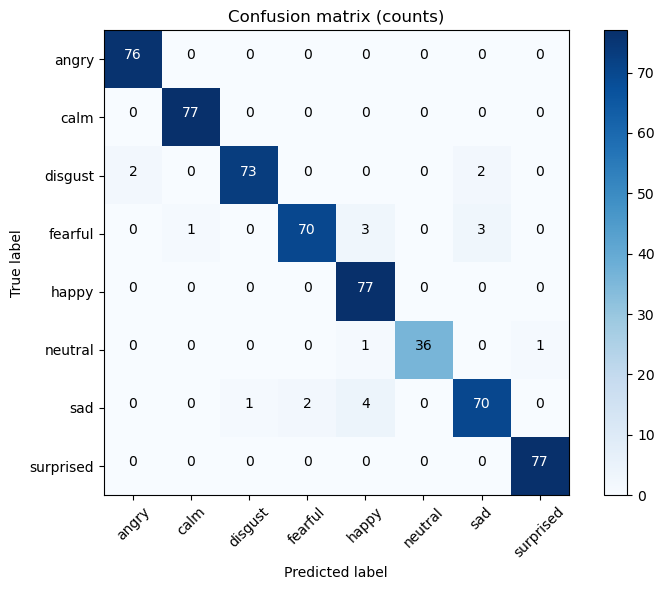

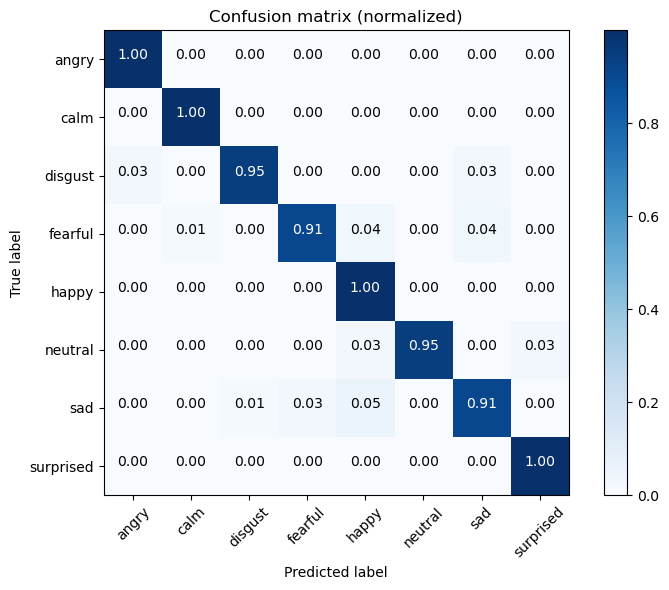

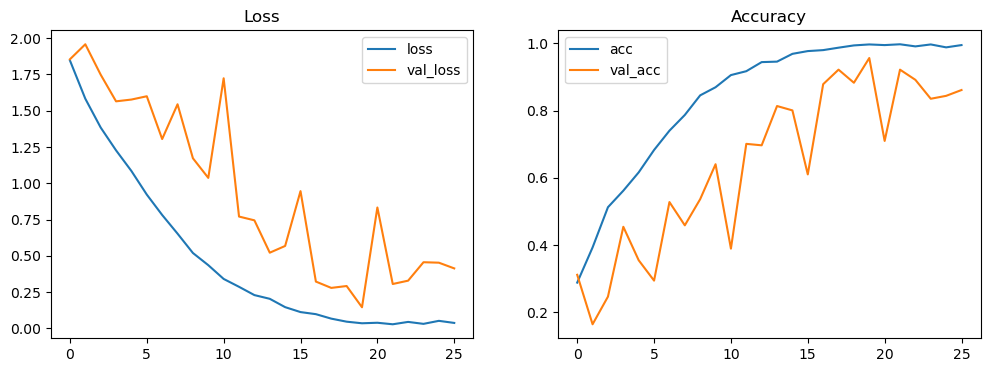

In [22]:
def main():
    X, Y = load_dataset(DATA_PATH)

    # limit classes if you want (example: use only a subset). Here we use all 8 emotions.
    labels = np.unique(Y)
    print("Emotions in data:", labels)

    # reshape X for CNN: currently (N, features, time) -> convert to (N, features, time, 1)
    X = X[..., np.newaxis]

    # encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(Y)
    num_classes = len(le.classes_)
    y_cat = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
    )

    print("Train shape:", X_train.shape, y_train.shape)
    print("Test shape:", X_test.shape, y_test.shape)

    # build model
    input_shape = (X.shape[1], X.shape[2])  # (features, time)
    model = build_cnn_model((input_shape[0], input_shape[1]), num_classes)
    model.summary()

    # callbacks
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        callbacks.ModelCheckpoint(MODEL_OUT, save_best_only=True, monitor='val_loss')
    ]

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=cb,
        verbose=1
    )

    # evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")


    cnn_result = {'Model': 'CNN', 'Test Accuracy': acc, 'Test Loss': loss}


    # predictions and classification report
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    print("Classification report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

    # confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plot_confusion_matrix(cm, classes=le.classes_, normalize=False, title='Confusion matrix (counts)')
    plot_confusion_matrix(cm, classes=le.classes_, normalize=True, title='Confusion matrix (normalized)')

    # plot training history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

if __name__ == "__main__":
    main()